In [1]:
from langchain_community.document_loaders import (
    UnstructuredHTMLLoader,
    BSHTMLLoader,
    TextLoader,
    JSONLoader,
)
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import (
    CharacterTextSplitter,
    RecursiveCharacterTextSplitter,
    MarkdownTextSplitter,
)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.vectorstores import Chroma
from langchain.chains import (
    RetrievalQA,
    ConversationalRetrievalChain,
    RetrievalQAWithSourcesChain,
)
from langchain.memory import ConversationBufferMemory
from langchain_community.llms import LlamaCpp, OpenAI

import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
from bert_score import plot_example, score

import logging
import pickle


logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

## Helpers

In [2]:
retrieval_strategy = "mmr"
model = "llama-2-13b-chat.Q4_K_M"

persist_directory = "./../embeddings"

In [3]:
def process_llm_response(llm_response):
    print("\n\nSources:")
    for i, source in enumerate(llm_response["source_documents"]):
        m = source.metadata
        print(f"{i + 1}. {m['course_title']} ({m['course_number']}): {m['heading']}")

In [4]:
class ResponseFormatter:
    def __init__(self):
        self.responses = {
            "question": [],
            "contexts": [],
            "answer": [],
            "ground_truth": [],
        }

    def add_response(self, llm_response, ground_truth):
        self.responses["question"].append(llm_response["query"])
        #self.responses["question"].append(llm_response["question"])
        self.responses["contexts"].append(
            [doc.page_content for doc in llm_response["source_documents"]]
        )
        self.responses["answer"].append(llm_response["result"])
        #self.responses["answer"].append(llm_response["answer"])
        self.responses["ground_truth"].append(ground_truth)

    def get_responses(self):
        return self.responses
    
    def get_dataframe(self):
        pd.DataFrame(self.responses[["question", "answer", "ground_truth"]])

## Vector Retriever

In [5]:
with open(f"{persist_directory}/embeddings.pickle", 'rb') as handle:
    embeddings = pickle.load(handle)


In [6]:
vectordb = Chroma(
    "documents", # or "transcripts"
    embedding_function=embeddings,
    persist_directory=persist_directory,
    collection_metadata={"hnsw:space": "cosine"},
)

In [7]:
retriever = vectordb.as_retriever(
    search_type=f"{retrieval_strategy}",
    search_kwargs={"k": 5, "fetch_k": 20},
)

## Quantized Model

In [9]:
# llm_open = LlamaCpp(
#     #model_path=f"./../models/{model}.gguf",  # https://huggingface.co/TheBloke/Llama-2-7B-GGUF
#     model_path=f"/Users/arnewman/.cache/lm-studio/models/TheBloke/Llama-2-13B-chat-GGUF/{model}.gguf",  # https://huggingface.co/TheBloke/Llama-2-7B-GGUF
#     n_ctx=4096,  # 4096 for Llama, 32*1024 for Mistral
#     n_gpu_layers=50,
#     temperature=0.15,
#     top_p=1,
#     top_k=40,
#     repeat_penalty=1.1,
#     max_tokens=1024,
#     callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
#     stream=True,
# )

llm_open = OpenAI(openai_api_base = "http://localhost:1234/v1",
                  openai_api_key = "hello",
                  temperature = 0.15,
                  top_p = 1,
                  max_tokens = 1024,
                  callback_manager = CallbackManager([StreamingStdOutCallbackHandler()]))


In [10]:
from langchain_core.prompts import PromptTemplate

template = '''
Use only the following pieces of context to answer the question at the end. 
Keep your answers concise and do not provide additional explanations or interpretations. 
If the answer cannot be deduced from the context, just say that you don't know the answer, don't try to make up an answer.

{context}

Question: {question}
Helpful Answer:
'''

In [11]:
qa_chain = RetrievalQA.from_chain_type(
#qa_chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm_open,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    verbose=True,
    chain_type_kwargs={
        "prompt": PromptTemplate(
            template=template,
            input_variables=["context", "question"])},
)

In [ ]:
print(qa_chain.combine_documents_chain.llm_chain.prompt.template)

In [12]:
query = "Which class involves time series analysis?"

llm_response = qa_chain(query)
process_llm_response(llm_response)

/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new RetrievalQA chain...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



> Finished chain.


Sources:
1. Data Mining II (SIADS 632): Learning Outcomes
2. n/a (n/a): General Academic Advising > Q: Can you advise me on which courses are the heaviest workload, the most difficult, etc?
3. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
4. Communicating Data Science Results (SIADS 523): Course Schedule
5. Math Methods I (SIADS 502): Course Syllabus Mads 502: Math Methods For Data Science Course Overview


## Run the Model

In [18]:
df = pd.read_csv("./evaluation_set.csv")

for _, row in df.iterrows():
    print(row["question"])

Which class involves time series analysis?
Who teaches the SQL and Databases class?
What are the prerequisites for Data Science for Social Good?
When are the office hours for the Math Methods course?
Are there any weekly readings for Milestone II?
What are the outcomes of Qualitative Inquiry?
What textbook is required for SIADS 505?
What textbook is required for Data Manipulation?
Which week of unsupervised learning covers DBSCAN?
How many credits are required to complete the MADS program?
How long do students have to complete the MADS program start to finish?
How many points is the comprehensive oral exam worth in SIADS 593?
What is the penalty for late submission in SIADS 630?
How do I get accommodations for a class?
What is a backpack?
When is the latest I can drop a course?
How do I get an override to take a class?
How do I take a leave of absence from the MADS program?
What are the prerequisites for Search and Recommender Systems?


In [19]:
formatter = ResponseFormatter()

# Or, use the cached one
# with open("./evaluation_set_formatter.pickle", 'rb') as handle:
#     formatter = pickle.load(handle)

In [20]:
for _, row in df.iterrows():
    llm_response = qa_chain(row["question"])
    process_llm_response(llm_response)

    formatter.add_response(llm_response, row["ground_truth"])

    # Save after each response in case this thing crashes
    with open(f"./cache/{retrieval_strategy}_{model}_formatter.pickle", 'wb') as handle:
        pickle.dump(formatter, handle)

    with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", 'wb') as handle:
        pickle.dump(formatter.get_responses(), handle)



> Entering new RetrievalQA chain...

> Finished chain.


Sources:
1. Data Mining II (SIADS 632): Learning Outcomes
2. n/a (n/a): General Academic Advising > Q: Can you advise me on which courses are the heaviest workload, the most difficult, etc?
3. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
4. Communicating Data Science Results (SIADS 523): Course Schedule
5. Math Methods I (SIADS 502): Course Syllabus Mads 502: Math Methods For Data Science Course Overview


> Entering new RetrievalQA chain...

> Finished chain.


Sources:
1. SQL and Databases (SIADS 511): Instructor And Course Assistants
2. SQL and Databases (SIADS 511): Course Outcomes
3. SQL and Databases (SIADS 511): Technology Requirements (Unique To This Course)
4. SQL and Databases (SIADS 511): Textbooks
5. SQL and Databases (SIADS 511): Course Schedule


> Entering new RetrievalQA chain...

> Finished chain.


Sources:
1. Data Science for Social Good (SIADS 688): Course Syllabus for S

## Evaluation with BERTScore

In [21]:
with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", "rb") as handle:
    rag_responses = pickle.load(handle)

In [22]:
for i in range(len(rag_responses["question"])):
    print(rag_responses["question"][i])
    print(">>>", rag_responses["ground_truth"][i])
    print("-" * 100)
    print(rag_responses["answer"][i])
    print("")
    print("=" * 100)
    print("=" * 100)
    print("")

Which class involves time series analysis?
>>> Data Mining II, SIADS 632 includes a particular focus on time series analysis.
----------------------------------------------------------------------------------------------------
  Based on the information provided, the class that involves time series analysis is:

* Data Mining II (SIADS 632)


Who teaches the SQL and Databases class?
>>> The primary instructor for SQL and Databases is Graham Hukill. Additional course assistants include, Derek Bruckner, Emily Schemanske, Jungseo Lee, and Toby Kemp.
----------------------------------------------------------------------------------------------------
  Based on the information provided, the instructor of the SQL and Databases class is Graham Hukill.


What are the prerequisites for Data Science for Social Good?
>>> SIADS 630, 631, and 694
----------------------------------------------------------------------------------------------------
  Based on the provided context, the prerequisites fo

In [23]:
responses_df = pd.DataFrame(rag_responses)

responses_df["eye_check"] = [
    1, # 'Which class involves time series analysis?',
    1, # 'Who teaches the SQL and Databases class?',
    1, # 'What are the prerequisites for Data Science for Social Good?',
    -1, # 'When are the office hours for the Math Methods course?',
    1, # 'Are there any weekly readings for Milestone II?',
    1, # 'What are the outcomes of Qualitative Inquiry?',
    -1, # 'What textbook is required for SIADS 505?',
    -1, # 'What textbook is required for Data Manipulation?',
    -1, # 'Which week of unsupervised learning covers DBSCAN?',
    1, # 'How many credits are required to complete the MADS program?',
    1, # 'How long do students have to complete the MADS program start to finish?',
    -1, # 'How many points is the comprehensive oral exam worth in SIADS 593?',
    1, # 'What is the penalty for late submission in SIADS 630?',
    1, # 'How do I get accommodations for a class?',
    -1, # 'What is a backpack?',
    1, # 'When is the latest I can drop a course?',
    1, # 'How do I get an override to take a class?',
    1, # 'How do I take a leave of absence from the MADS program?',
    1, # 'What are the prerequisites for Search and Recommender Systems?'
]

In [24]:
scores = [
    [
        t.item()
        for t in score(
            [rag_responses["answer"][i]],
            [rag_responses["ground_truth"][i]],
            rescale_with_baseline=True,
            lang="en",
        )
    ]
    for i in range(len(rag_responses["question"]))
]

with open(f"./cache/{retrieval_strategy}_{model}_bertscores.pickle", "wb") as handle:
    pickle.dump(scores, handle)

In [25]:
with open(f"./cache/{retrieval_strategy}_{model}_bertscores.pickle", "rb") as handle:
    scores = pickle.load(handle)

bert_df = pd.concat(
    [
        responses_df,
        pd.DataFrame(scores, columns=["precision", "recall", "f1"]),
    ],
    axis="columns",
)

bert_df["abs_diff"] = (bert_df["eye_check"] - bert_df["f1"]).abs()

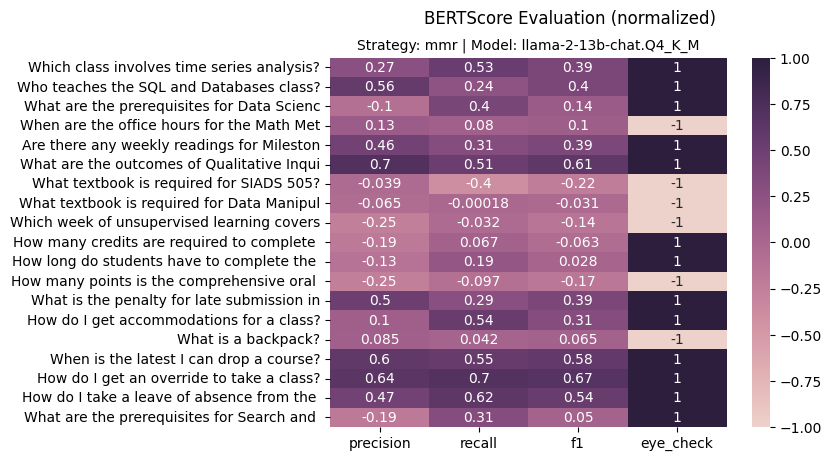

In [26]:
sns.heatmap(
    bert_df[["precision", "recall", "f1", "eye_check"]],
    yticklabels=bert_df["question"].str[:42],
    annot=True,
    cmap=sns.cubehelix_palette(as_cmap=True),
)

plt.suptitle("BERTScore Evaluation (normalized)")
plt.title(f"Strategy: {retrieval_strategy} | Model: {model}", fontsize=10)

plt.show()